# Amadeus Hiring Test

## First exercise: 
Count the number of lines in Python for each file

In [2]:
def nbrLine(filename):
    nLine = 0
    with open(filename, "r") as f:
        for line in f:
            nLine += 1
    return (nLine)

print 'The number of lines for bookings.csv is' , nbrLine('./data/bookings.csv')
print 'The number of lines for searches.csv is' , nbrLine('./data/searches.csv')

The number of lines for bookings.csv is 10000011
The number of lines for searches.csv is 20390199


## Second exercise: 
Top 10 arrival airports in the world in 2013 (using the bookings file) Arrival airport is the column arr_port. It is the IATA code for the airport To get the total number of passengers for an airport, you can sum the column pax, grouping by arr_port. Note that there is negative pax. That corresponds to cancelations. So to get the total number of passengers that have actually booked, you should sum including the negatives (that will remove the cancelled bookings).
Print the top 10 arrival airports in the standard output, including the number of passengers.
Bonus point: Get the name of the city or airport corresponding to that airport (programatically, we suggest to have a look at GeoBases in Github) Bonus point: Solve this problem using pandas (instead of any other approach)


In [3]:
import pandas as pd
from GeoBases import GeoBase

def topAirports(filename, n = 10):
    # Create an empty Dataframe to store the final results
    paxArr = pd.DataFrame(columns=['arr_port','pax'])
    # Create a TextFileReader in chunk to reduce the memory load
    reader = pd.read_table(filename, sep='^', chunksize = 100000, usecols=['arr_port','pax'])
    for chunk in reader:
        # Format column names
        chunk.columns = chunk.rename(columns=lambda x: x.strip()).columns.values
        # Sum by arrival airport
        paxArr = pd.concat([paxArr, chunk[['arr_port','pax']].groupby('arr_port').sum().reset_index()])
    # Keep only the 10 top arrival airports and get their names
    topAirport = paxArr[['arr_port','pax']].groupby('arr_port').sum().sort('pax', ascending = 0).reset_index()[0:(n-1)]
    for k, airport in enumerate(topAirport['arr_port']):
        topAirport.loc[k,'airport'] = geo_o.get(airport.strip(), 'name', default="Undefined")
    print "\nTop 10 arrival airports:\n%s" % topAirport
    return(topAirport)

geo_o = GeoBase(data='ori_por', verbose=False)
topAirport = topAirports('./data/bookings.csv', 10)


Top 10 arrival airports:
   arr_port    pax                               airport
0  LHR       88809               London Heathrow Airport
1  MCO       70930         Orlando International Airport
2  LAX       70530     Los Angeles International Airport
3  LAS       69630       Mc Carran International Airport
4  JFK       66270  John F Kennedy International Airport
5  CDG       64490             Paris - Charles-de-Gaulle
6  BKK       59460                          Suvarnabhumi
7  MIA       58150           Miami International Airport
8  SFO       58000   San Francisco International Airport


## Third exercise: 
Plot the monthly number of searches for flights arriving at Málaga, Madrid or Barcelona. For the arriving airport, you can use the Destination column in the searches file. Plot a curve for Málaga, another one for Madrid, and another one for Barcelona, in the same figure.
Bonus point: Solving this problem using pandas (instead of any other approach)


2015-07-26 22:21:43 811000: Retrieving Data for Malaga
2015-07-26 22:23:18 972000: Retrieving Data for Madrid
2015-07-26 22:24:52 707000: Retrieving Data for Barcelona
2015-07-26 22:26:28 769000: Plot the data


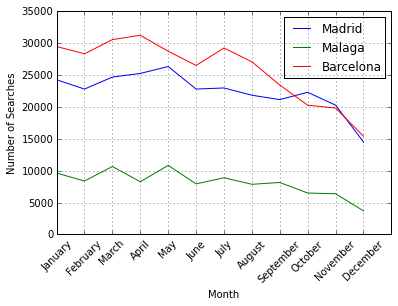

In [6]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot  as plt
from datetime import datetime

def log(msg):
    # Create a log message with the datetime
    print datetime.now().strftime("%Y-%m-%d %H:%M:%S %f") + ': ' + msg

def destinationAirport(filename, destination):
    reader = pd.read_table(filename, sep='^', chunksize = 10000, usecols=['Date','Destination'])
    totSearches = pd.DataFrame(columns = ['Month',destination])
    i = 0
    for chunk in reader:
        chunk = chunk[chunk['Destination'] ==  destination]
        chunk['Date']  = pd.to_datetime(chunk['Date'])
        chunk['Month'] = chunk['Date'].dt.month
        chunk = chunk.groupby(['Month'], as_index = False).count()
        del chunk['Destination']
        chunk.columns = ['Month',destination]
        totSearches = pd.concat([totSearches, chunk])
    totSearches = totSearches.groupby('Month').sum()
    return totSearches

filename = './data/searches.csv'
log('Retrieving Data for Malaga')
totMalaga = destinationAirport(filename, 'AGP')
log('Retrieving Data for Madrid')
totMadrid = destinationAirport(filename, 'MAD')
log('Retrieving Data for Barcelona')
totBarcelona = destinationAirport(filename, 'BCN')

log('Plot the data')
plt.plot(totMadrid)
plt.plot(totMalaga)
plt.plot(totBarcelona)

#set plot attributes
plt.legend(('Madrid','Malaga','Barcelona'))
plt.xticks(range(12),
           ['January', 'February', 'March', 'April', 'May', 'June', 
            'July','August','September','October','November','December'], 
           rotation=45)
plt.xlabel('Month')
plt.ylabel('Number of Searches')
plt.grid()
plt.show()

# Fourth exercise: 
Match searches with bookings For every search in the searches file, find out whether the search ended up in a booking or not (using the info in the bookings file). For instance, search and booking origin and destination should match. For the bookings file, origin and destination are the columns dep_port and arr_port, respectively. Generate a CSV file with the search data, and an additional field, containing 1 if the search ended up in a booking, and 0 otherwise.
Bonus point: Solving this problem using pandas (instead of any other approach)


In [ ]:
# In order to find out wheter a search ended up in a booking, I just used the origin and destination. 
# To have a first glimpse into the file, this is enough. Obviously, the user uniqueness need also to be certified. 
# This is not done here. 

import pandas as pd

booking = pd.read_table('./data/bookings.csv', sep='^', chunksize = 10000)
searches = pd.read_table('./data/searches.csv', sep='^', chunksize = 10000)

bookingList = list()
for chunkBooking in booking:
    zipped = zip(map(str.strip, chunkBooking['dep_port']) , map(str.strip, chunkBooking['arr_port']))
    bookingList.extend(zipped)
    seen = set()
    bookingList = [item for item in bookingList if item[1] not in seen and not seen.add(item[1])]

searchesIndex = 0
booked = list()
for chunkSearches in searches:
    for k in range(1,len(chunkSearches)):
        searchesIndex += 1
        bookedSearch = [False]*len(chunkSearches)
        fromSearch = chunkSearches.ix[k, 'Origin']
        toSearch = chunkSearches.ix[k, 'Destination']
        if (fromSearch, toSearch) in bookingList:
            booked.append(1)
        else:
            booked.append(0)

pd.merge(searches, booked, how = 'left').to_csv(path='./data/searches_matched.csv')